In [1]:
import numpy as np
import scipy.io as io
import pandas as pd
import sys
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold, StratifiedKFold
from IPython.display import clear_output

In [2]:
directory = '/home/data/Project_ASD/' + os.environ["USER"]+'/' #feel free to upload data from /Project_ASD/seyda
data = np.load(directory+'targetP3s_equal.npz', allow_pickle=True)
targetP3s_equal = data['targetP3s_equal']
subjects = data['subjects']
n_subj,n_elec,n_trials=targetP3s_equal.shape

In [3]:
test_pca = np.arange(1,n_subj,3) 
test_C=np.logspace(-5, 0, 10)  
pca = PCA()
param_grid = {'pca__n_components': test_pca,'clf__C': test_C}
print('Testing '+ str(param_grid['pca__n_components'].shape[0]) +' different n_pca and '+str(param_grid['clf__C'].shape[0]) +' regularization parameters')

Testing 14 different n_pca and 10 regularization parameters


In [4]:
clfs={}
clfs['LR-L2']= LogisticRegression(max_iter=5000, tol=1.0) #default=’l2’
clfs['LR-L1']= LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, tol=1.0)
clfs['LDA']=  LinearDiscriminantAnalysis(tol=1e-3)
clfs['QDA'] = QuadraticDiscriminantAnalysis(tol=1e-3)
clf_key ='LR-L1' #this is the only line you are likely to edit 
pipe = Pipeline(steps=[('pca', pca), ('clf', clfs[clf_key])])

In [5]:
#check for nan values. 
idx = pd.isnull(targetP3s_equal.mean((1,2)))== False #RuntimeWarning 
targetP3s_equal = targetP3s_equal[idx,:,:]
subjects = subjects[idx]
assert subjects.shape[0] == targetP3s_equal.shape[0]
n_subj = subjects.shape[0]


/home/seyda/.local/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [6]:
# here is your experiment. run it! go for it! 
y=subjects[...,0]
X = targetP3s_equal.reshape(n_subj,n_elec*n_trials)**2        
search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=15, verbose=0)
search.fit(X, y);

exp_identifier=clf_key+'-single-'+str(y.shape[0])+'x'+str(X.shape[1])+'features'+'-pca'+str(param_grid['pca__n_components'].shape[0])+'-C'+str(param_grid['clf__C'].shape[0])


In [7]:
#calculate and write best scores 
import time
year, month, day, hour, min = map(str, time.strftime("%Y %m %d %H %M").split())

best = np.zeros((1,1,3), dtype=object)
for i in range(1):
    for j in range(1):
        best[i,j,0]=search.best_score_*100
        best[i,j,1]=search.best_params_['clf__C']
        best[i,j,2]=search.best_params_['pca__n_components']
with open('best.csv','a') as fd:
    fd.write("\n"+ year+'-'+month+'-'+day+'-'+hour+min+"\n")
    fd.write(exp_identifier+"\n")   
    fd.write(str(best)+"\n")

best

array([[[70.0, 0.0016681005372000592, 19]]], dtype=object)

In [8]:
# save cv_results  
mean_score = np.zeros((1,1), dtype=object)
std_score = np.zeros((1,1), dtype=object)
for i in range(1):
    for j in range(1):
        for k in range(test_C.shape[0]):
            std_score[i,j]=search.cv_results_['std_test_score'].reshape(test_C.shape[0],test_pca.shape[0])
            mean_score[i,j]=search.cv_results_['mean_test_score'].reshape(test_C.shape[0],test_pca.shape[0])
#exp_identifier looks like this: LR-L2-pca12-C21-78080features
save_name=year+'-'+month+'-'+day+'-'+hour+min+'-'+exp_identifier+'.npz' 
np.savez(directory+'/scores/'+save_name, mean_score=mean_score, std_score=std_score,test_C=test_C,test_pca=test_pca,best=best)


In [9]:
import seaborn as sns #pip3 install seaborn
import matplotlib.pyplot as plt
def errorfill(x, y, yerr, color=None, label=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, ymax, ymin, color=color, label=label, alpha=alpha_fill)
    return ax


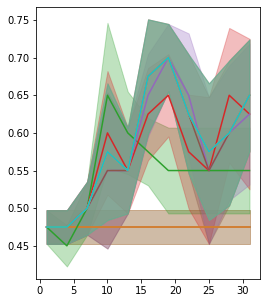

In [10]:
fig_dir ='/home/data/Project_ASD/' + os.environ["USER"]+'/figures/'
fig = plt.figure(figsize=(4,5))
for k in range(test_C.shape[0]):
    errorfill(test_pca,mean_score[i,j][k].T, std_score[i,j][k].T/np.sqrt(5))
plt.savefig(fig_dir+save_name+'.png')